# Structure of the Submission Model


In [ ]:
import tensorflow as tf

class model:
    def __init__(self):
        self.model = tf.keras.models.load_model('saved_model')

    def predict(self, X):

        # Note: this is just an example.
        # Here the model.predict is called, followed by the argmax
        out = self.model.predict(X)
        print(type(out))
        out = (out > 0.5).astype(int)  # Shape [BS]
        print(type(out))
        return tf.convert_to_tensor(np.squeeze(out, axis=-1))

#Downloading the Dataset

In [1]:
import gdown
file_id = '1llWCmIbaW-uHvZcD-soT8DJQJYmm8zAA'
file_path = '/content/dataset.zip'

gdown.download(f'https://drive.google.com/uc?id={file_id}', file_path, quiet=False)
!unzip /content/dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1llWCmIbaW-uHvZcD-soT8DJQJYmm8zAA
To: /content/dataset.zip
100%|██████████| 208M/208M [00:03<00:00, 61.7MB/s]


Archive:  /content/dataset.zip
  inflating: public_data.npz         


#Imports

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.applications import InceptionV3, MobileNetV2
from keras.models import Model
from keras.optimizers import Adam, AdamW
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Load dataset
data = np.load('/content/public_data.npz', allow_pickle=True)
images = data['data']
labels = data['labels']

# Removing outliers
shrek_indices = []
trol_indices = []
for i, image in enumerate(images):
  if np.sum(images[506] - image) == 0:
    shrek_indices.append(i)
  elif np.sum(images[338] - image) == 0:
    trol_indices.append(i)
indices_to_remove = shrek_indices + trol_indices
images = np.delete(images, indices_to_remove, axis=0)
labels = np.delete(labels, indices_to_remove)

#Data Analysis

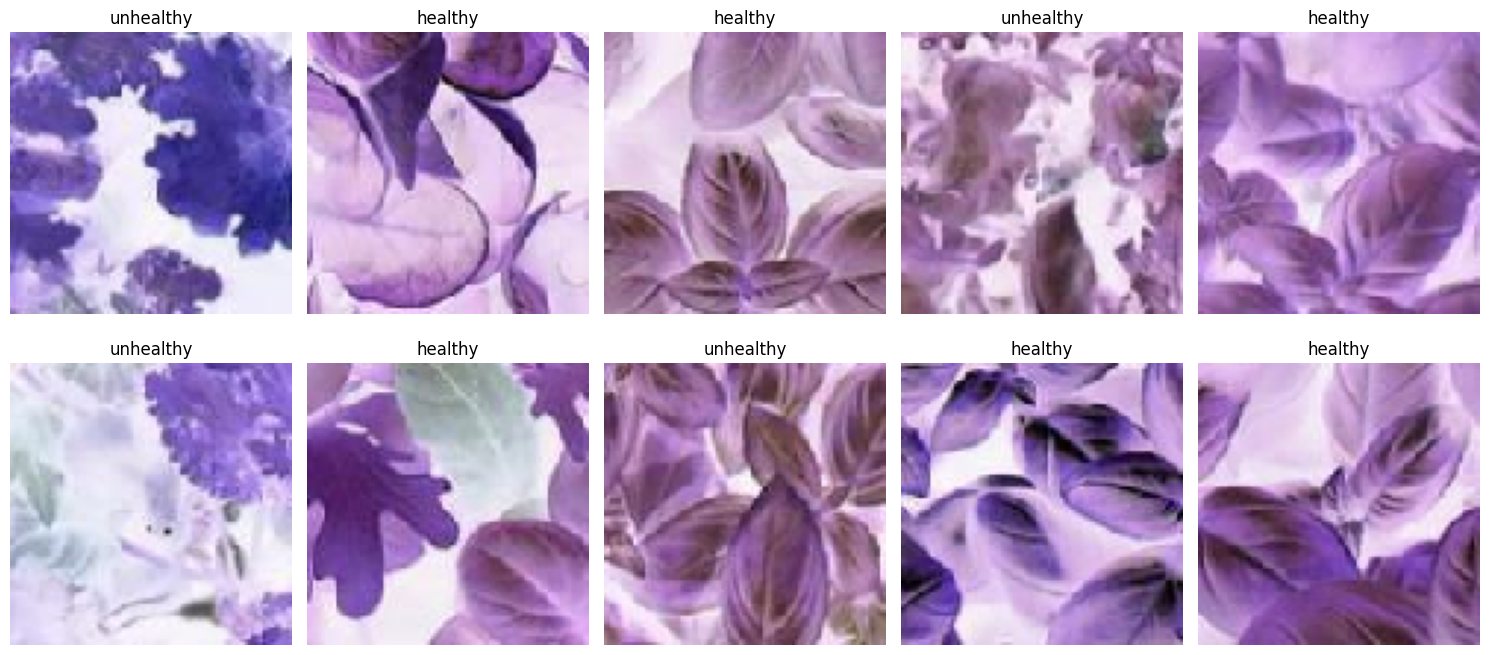

In [ ]:
import matplotlib.pyplot as plt

# Select random 10 indices from the dataset
random_indices = np.random.choice(len(images), 10, replace=False)

# Get the random images and labels
random_images = images[random_indices]
random_labels = labels[random_indices]

# Normalize the images to [0, 1]
random_images = random_images.astype('float32') / 255

# Plot the random images with labels
plt.figure(figsize=(15, 7))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    inverted_image = 255 * np.ones_like(random_images[i]) - random_images[i]
    from PIL import Image, ImageChops

    # Opening the test image, and saving it's objec

    # Passing the image object to invert()
    numpy_array_uint8 = (random_images[i] * 255).astype(np.uint8)

    inv_img = ImageChops.invert(Image.fromarray(numpy_array_uint8))
    plt.imshow(inv_img)
    plt.title(random_labels[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

#Model

In [ ]:
"""
for i, img in enumerate(images):
  numpy_array_uint8 = image.astype(np.uint8)

  inv_img = ImageChops.invert(Image.fromarray(numpy_array_uint8))
  images[i] = np.array(inv_img)
"""

In [3]:
BEST_MODEL_PATH = "/content/best_model_weights.h5"

In [32]:
from keras.layers.experimental.preprocessing import Rescaling
from keras import Input
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.applications import Xception, InceptionResNetV2


# Convert labels to binary format
labels_binary = np.where(labels == 'healthy', 0, 1)

# Split dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels_binary, test_size=0.2, stratify=labels_binary, random_state=8)

normalization_layer = Rescaling(1./255)

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# Add custom layers for binary classification
inputs = Input(shape=(96, 96, 3), name="input")
x = normalization_layer(inputs)
x = base_model(x)

x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=predictions)

# Compile the model
model.compile(optimizer=AdamW(), loss='binary_crossentropy', metrics=["accuracy"])

for i, layer in enumerate(model.layers):
  if i < 4:
    layer.trainable = False

model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 rescaling_15 (Rescaling)    (None, 96, 96, 3)         0         
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 flatten_8 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_60 (Dropout)        (None, 2048)              0         
                                                                 
 dense_60 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_61 (Dropout)        (None, 1024)              0  

#Training

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size=128

data_gen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip = True
)

# Apply the data generator to the training data
train_generator = data_gen.flow(X_train, y_train, batch_size=batch_size)

In [22]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Class weights: {class_weights_dict}")

Class weights: {0: 0.8068365043534343, 1: 1.3147661586967945}


In [31]:
from sklearn.model_selection import StratifiedKFold
from keras.optimizers import RMSprop
from keras.applications import InceptionResNetV2, InceptionV3
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

i = -1
for train_index, val_index in kf.split(images, labels_binary):
    i += 1
    if i != 1:
      continue
    X_train, X_val = images[train_index], images[val_index]
    y_train, y_val = labels_binary[train_index], labels_binary[val_index]

    # Create a new instance of the model for each fold
    normalization_layer = Rescaling(1./255)

    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

    # Add custom layers for binary classification
    inputs = Input(shape=(96, 96, 3), name="input")
    x = normalization_layer(inputs)
    x = base_model(x)

    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.2)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=predictions)

    for iter, layer in enumerate(model.layers):
      if iter < 4:
        layer.trainable = False
    # Compile the model
    model.compile(optimizer=AdamW(), loss="binary_crossentropy", metrics=["accuracy"])
    # Train the model with early stopping
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)
    checkpoint = ModelCheckpoint(f"model_{i}_weights.h5", save_best_only=True, save_weights_only=True, monitor='val_accuracy', mode='max', verbose=1)


    model.fit(train_generator, epochs=60, class_weight=class_weights_dict, validation_data=(X_val, y_val), callbacks=[checkpoint])

    # Evaluate the model on the test data
    loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f'Validation accuracy: {accuracy}')




Epoch 1/60
32/32 [==============================] - ETA: 0s - loss: 0.7062 - accuracy: 0.5426
Epoch 1: val_accuracy improved from -inf to 0.71129, saving model to model_1_weights.h5
32/32 [==============================] - 22s 395ms/step - loss: 0.7062 - accuracy: 0.5426 - val_loss: 0.6774 - val_accuracy: 0.7113
Epoch 2/60
32/32 [==============================] - ETA: 0s - loss: 0.6614 - accuracy: 0.6283
Epoch 2: val_accuracy improved from 0.71129 to 0.72228, saving model to model_1_weights.h5
32/32 [==============================] - 11s 339ms/step - loss: 0.6614 - accuracy: 0.6283 - val_loss: 0.5725 - val_accuracy: 0.7223
Epoch 3/60
32/32 [==============================] - ETA: 0s - loss: 0.6178 - accuracy: 0.6583
Epoch 3: val_accuracy did not improve from 0.72228
32/32 [==============================] - 10s 310ms/step - loss: 0.6178 - accuracy: 0.6583 - val_loss: 0.5662 - val_accuracy: 0.7053
Epoch 4/60
32/32 [==============================] - ETA: 0s - loss: 0.6034 - accuracy: 0.689

#Test

32/32 [==============================] - 3s 26ms/step


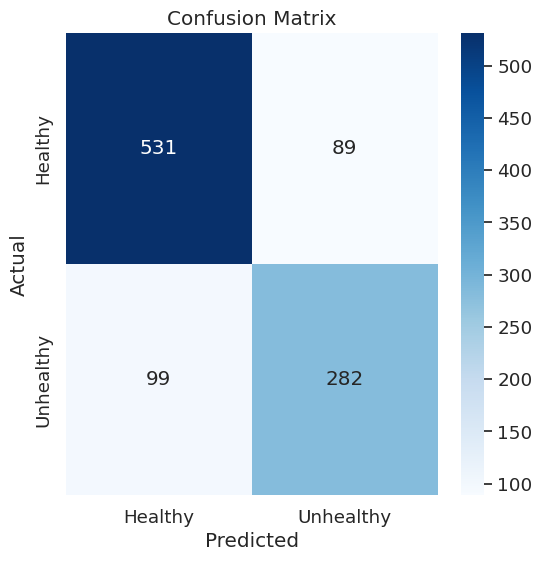

In [24]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model

# Load the pre-trained model
model.load_weights("model_1_weights.h5")

# Make predictions on the validation set
y_pred = model.predict(X_val)

y_pred_classes = (y_pred > 0.5).astype(int)
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_classes)
class_names = ["Healthy", "Unhealthy"]

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 6))
sns.set(font_scale=1.2)  # Adjust the font size for better visibility
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred_classes))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       620
           1       0.76      0.74      0.75       381

    accuracy                           0.81      1001
   macro avg       0.80      0.80      0.80      1001
weighted avg       0.81      0.81      0.81      1001



#Convert to the required format

In [26]:
import tensorflow as tf

tf.keras.models.save_model(model, "saved_model")

# Move Model to Drive

In [27]:
# mount it
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
# copy it there
!cp -r saved_model /content/drive/MyDrive